In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tss
import numpy as np
import ark

Using TSS with a basic Gaussians example
--------------------------------------------------

The Gaussians class is a simple model that generates samples from the normal distribution with standard deviation 1 centered at a given rung and can return the array of per-rung energies for a given sample

In [2]:
class Gaussians:    
    def __init__(self):
        self.state = 0
        self.deviation = 1

    def sample(self, rung):
        self.state = np.random.normal(loc = rung, scale = self.deviation)

    def energy(self, N):
        return ((self.state - np.arange(N)) / self.deviation)**2 / 2

We build a graph with 32 rungs and three windows, one covering all of the rungs and each of the other two covering half (the layout below)

     [--------------------------------]
    [----------------][----------------]

In [3]:
rung_count = 32
window_size = 32
gb = tss.GraphBuilder()
edge_id = gb.add_edge(['left', 'right'], [rung_count], [window_size])
gb.build()
graph_ark = gb.cerealize()

Create the TSS estimator from the graph ark, running with a single replica

In [4]:
estimator = tss.Sampler(graph_ark, 1)
g = Gaussians()

Run the simulation with 10000 timesteps and record the visited rungs as well as the end to end difference in the free energy estimates

In [5]:
timesteps = 10000
delta_fes = np.zeros(timesteps)
rungs = np.zeros(timesteps)
for i in range(timesteps):
    current_rung = estimator.getReplicaRung(0)
    rungs[i] = current_rung
    g.sample(current_rung)
    estimator.setEnergies(0, g.energy(rung_count))
    estimator.step(np.random.randint(1e8))
    estimator.updateReporting()
    free_energy = estimator.getFreeEnergies()
    delta_fes[i] = free_energy[-1] - free_energy[0]

Plot the delta FE and rung traces

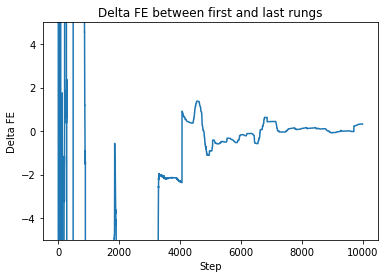

In [6]:
plt.plot(delta_fes)
plt.title('Delta FE between first and last rungs')
plt.xlabel('Step')
plt.ylabel('Delta FE')
plt.ylim(-5, 5)
plt.show()

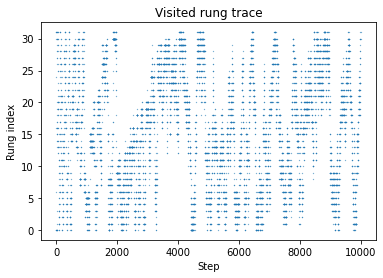

In [7]:
plt.plot(rungs, '.', markersize=0.5)
plt.title('Visited rung trace')
plt.xlabel('Step')
plt.ylabel('Rung index')
plt.show()

Section 5.2 from the paper appendix: effect of the Fisher-Rao metric
-------------------------------------------------------------------------------






In [8]:
class GaussiansTwoLengthscale:    
    def __init__(self):
        self.state = 0
        self.deviation = 1
        
    def mean(self, lam):
        return np.where(lam < 5./6, 0.05 * 6 * lam / 5, 0.05 + 6 * (15 - 0.05) * (lam - 5./6))

    def sample(self, lam):
        self.state = np.random.normal(loc = self.mean(lam), scale = self.deviation)

    def energy(self, N):
        energies = np.zeros(N)
        means = self.mean(np.arange(N) / (N - 1))
        return ((self.state - means) / self.deviation)**2 / 2

In [9]:
rung_count = 60
window_size = 60
gb = tss.GraphBuilder()
edge_id = gb.add_edge(['left', 'right'], [rung_count], [window_size], primary_window_tiling_only=True)
gb.build()
graph_ark_two = gb.cerealize()

In [15]:
def run_trials(use_coordinate_invariance):
    trials = 100
    l2_norm = np.zeros(trials)
    end_to_end_norm = np.zeros(trials)
    mean_weights = np.zeros(rung_count)

    for trial in range(trials):
        print('Trial', trial)
        estimator = tss.Sampler(graph_ark_two, 1, use_coordinate_invariance)
        gt = GaussiansTwoLengthscale()

        timesteps = 100000
        for i in range(timesteps):
            current_rung = estimator.getReplicaRung(0)
            gt.sample(current_rung / float(rung_count - 1))
            estimator.setEnergies(0, gt.energy(rung_count))
            estimator.step(np.random.randint(1e8))
            estimator.updateReporting()
        free_energy = np.array(estimator.getFreeEnergies())
        l2_norm[trial] = np.sqrt(np.sum((free_energy - free_energy[0])**2))
        end_to_end_norm[trial] = np.abs(free_energy[-1] - free_energy[0])
        mean_weights += np.array(estimator.getRungWeights())
        
    mean_weights /= trials
    return l2_norm, end_to_end_norm, mean_weights

print('With coordinate invariance')
with_CI_l2, with_CI_e2e, mean_weights = run_trials(True)
print('Without coordinate invariance')
without_CI_l2, without_CI_e2e, _ = run_trials(False)

With coordinate invariance
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 10
Trial 11
Trial 12
Trial 13
Trial 14
Trial 15
Trial 16
Trial 17
Trial 18
Trial 19
Trial 20
Trial 21
Trial 22
Trial 23
Trial 24
Trial 25
Trial 26
Trial 27
Trial 28
Trial 29
Trial 30
Trial 31
Trial 32
Trial 33
Trial 34
Trial 35
Trial 36
Trial 37
Trial 38
Trial 39
Trial 40
Trial 41
Trial 42
Trial 43
Trial 44
Trial 45
Trial 46
Trial 47
Trial 48
Trial 49
Trial 50
Trial 51
Trial 52
Trial 53
Trial 54
Trial 55
Trial 56
Trial 57
Trial 58
Trial 59
Trial 60
Trial 61
Trial 62
Trial 63
Trial 64
Trial 65
Trial 66
Trial 67
Trial 68
Trial 69
Trial 70
Trial 71
Trial 72
Trial 73
Trial 74
Trial 75
Trial 76
Trial 77
Trial 78
Trial 79
Trial 80
Trial 81
Trial 82
Trial 83
Trial 84
Trial 85
Trial 86
Trial 87
Trial 88
Trial 89
Trial 90
Trial 91
Trial 92
Trial 93
Trial 94
Trial 95
Trial 96
Trial 97
Trial 98
Trial 99
Without coordinate invariance
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial

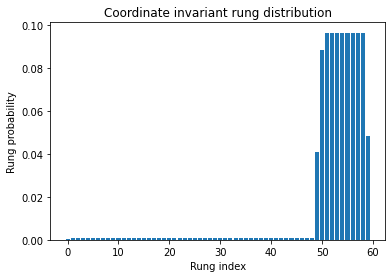

In [25]:
plt.bar(list(range(rung_count)), mean_weights)
plt.title('Coordinate invariant rung distribution')
plt.xlabel('Rung index')
plt.ylabel('Rung probability')
plt.show()

In [20]:
print('With C.I., mean L2 norm:', np.mean(with_CI_l2))
print('No C.I., mean L2 norm:', np.mean(without_CI_l2))
print('With C.I., mean end-to-end absolute error:', np.mean(with_CI_e2e))
print('No C.I., mean end-to-end absolute error:', np.mean(without_CI_e2e))

With C.I., mean L2 norm: 0.18774202877310098
No C.I., mean L2 norm: 0.354431259391693
With C.I., mean end-to-end absolute error: 0.07473691817812807
No C.I., mean end-to-end absolute error: 0.15567992865862237
